# Predicting Bitcoin Price Using LSTM

## Faizan Hameed

### 1-Downloading Dataset in Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Run only 1st time
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
#Check the present working directory
import os
os.getcwd() 


'/content/gdrive/My Drive/Kaggle'

In [5]:
#Run this cell only 1st time to download the dataset in spacified directory 
# Copy the API command from Kaggle Dataset and paste(using !) to download the data
#!kaggle datasets download -d mczielinski/bitcoin-historical-data

In [6]:
#check the content in our directory
!ls

BC_Data.csv  coin_Bitcoin.csv  final_model.h5  kaggle.json  model_final.json


In [7]:
#Run only once to unzip the Dataset
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

### 2-Importing Libraries 

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, LeakyReLU,Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.models import model_from_json
from scipy import stats
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 3- Importing dataset

In [9]:
d_frame=pd.read_csv('BC_Data.csv')
print('1st 5 rows')
d_frame.head(5)




1st 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#d_frame.info()# Here datatype of Timestamp is "int64".

In [11]:
#d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],infer_datetime_format=True) #We converted in "Timestamp" format. Now datatype of "Timestamp" is object but we used"infer_datetime_format=True" that converts "Timestamp" format from "object" to "datetime64" format)
#d_frame.head()

In [12]:
#d_frame.info()

In [13]:
d_frame.shape # No of rows and columns in this dataframe 

(4857377, 8)

### 4-Data Cleaning

We are going to convert time stemp to date.

In [14]:
d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],unit='s').dt.date #We converted in time stamp format
#d_frame = d_frame.set_index(['Timestamp']) #If we want to set "Timestamp" as index.
d_frame.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],infer_datetime_format=True) #We converted in "Timestamp" format. Now datatype of "Timestamp" is object but we used"infer_datetime_format=True" that converts "Timestamp" format from "object" to "datetime64" format)
#print('Top 5 rows of dataframe')
#d_frame.head()

In [16]:
print('last 5 rows')
d_frame.tail(5)

last 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,2021-03-30,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,2021-03-31,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


We can see that our data is upto date.

In [17]:
d_frame.shape # No of rows and columns in this dataframe 

(4857377, 8)

Now we are going to remove all un necessary columns.

In [18]:
d_frame.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [19]:
d_frame.drop(['Open',"High",'Low','Close'] , inplace=True, axis=1)
d_frame

,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,0.455581,2.000000,4.390000
1,2011-12-31,NaN,NaN,NaN
2,2011-12-31,NaN,NaN,NaN
3,2011-12-31,NaN,NaN,NaN
4,2011-12-31,NaN,NaN,NaN
...,...,...,...,...
4857372,2021-03-30,1.384487,81259.372187,58692.753339
4857373,2021-03-30,7.294848,428158.146640,58693.226508
4857374,2021-03-30,1.705682,100117.070370,58696.198496
4857375,2021-03-30,0.720415,42332.958633,58761.866202


In [20]:
#Renaming Column "Weighted_Price"
d_frame.rename(columns={'Weighted_Price': 'Bitcoin_Price'}, inplace=True)
d_frame.head(10)

,Timestamp,Volume_(BTC),Volume_(Currency),Bitcoin_Price
0,2011-12-31,0.455581,2.0,4.39
1,2011-12-31,NaN,NaN,NaN
2,2011-12-31,NaN,NaN,NaN
3,2011-12-31,NaN,NaN,NaN
4,2011-12-31,NaN,NaN,NaN
5,2011-12-31,NaN,NaN,NaN
6,2011-12-31,NaN,NaN,NaN
7,2011-12-31,NaN,NaN,NaN
8,2011-12-31,NaN,NaN,NaN
9,2011-12-31,NaN,NaN,NaN


In [21]:
#grouping=d_frame.groupby('Timestamp')
#df=grouping[ 'Volume_(BTC)','Volume_(Currency)', 'Bitcoin_Price'].mean()
#df

We have selected two years of data starting from 1st Feb 2019.

In [22]:
#d_select = d_frame.loc[d_frame['Timestamp'] > pd.to_datetime('2019-01-01')]
#d_select.head(5)

In [23]:
d_frame.shape

(4857377, 4)

There are multiple readings at every day in dataframe so  grouping data w.r.t "Timestamp" and taking the mean of each group.

In [24]:
grouping=d_frame.groupby('Timestamp')
df=grouping[ 'Volume_(BTC)','Volume_(Currency)', 'Bitcoin_Price'].mean()
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Timestamp,,,
2011-12-31,23.829470,106.330084,4.471603
2012-01-01,7.200667,35.259720,4.806667
2012-01-02,19.048000,95.240000,5.000000
2012-01-03,11.004660,58.100651,5.252500
2012-01-04,11.914807,63.119577,5.208159
...,...,...,...
2021-03-27,1.823877,100884.732367,55193.357260
2021-03-28,1.447939,80632.115263,55832.958824
2021-03-29,3.732887,213754.555988,56913.993819


In [25]:
df.shape

(3376, 3)

In [26]:
# We want to replace missing values i.e "?" to Python's default missing value marker "NaN"
df.replace("?", np.nan, inplace = True)
df.head(10)

,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Timestamp,,,
2011-12-31,23.829470,106.330084,4.471603
2012-01-01,7.200667,35.259720,4.806667
2012-01-02,19.048000,95.240000,5.000000
2012-01-03,11.004660,58.100651,5.252500
2012-01-04,11.914807,63.119577,5.208159
2012-01-05,4.514373,27.987370,6.284127
2012-01-06,2.420196,15.914659,6.438999
2012-01-07,0.295858,2.011834,6.800000
2012-01-08,2.500000,17.300000,6.950000


In [27]:
#After converting to default now detecting missing data(we can use .isnull()
#or .notnull() method)
#True" stands for missing value, while "False" stands for not missing value.
missing_values = df.isnull()
missing_values.head(10)

,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Timestamp,,,
2011-12-31,False,False,False
2012-01-01,False,False,False
2012-01-02,False,False,False
2012-01-03,False,False,False
2012-01-04,False,False,False
2012-01-05,False,False,False
2012-01-06,False,False,False
2012-01-07,False,False,False
2012-01-08,False,False,False


In [28]:
# Checking the missing values in each column
for column in missing_values.columns.values.tolist():
    print(column)
    print (missing_values[column].value_counts())
    print("") 

Volume_(BTC)
False    3376
Name: Volume_(BTC), dtype: int64

Volume_(Currency)
False    3376
Name: Volume_(Currency), dtype: int64

Bitcoin_Price
False    3376
Name: Bitcoin_Price, dtype: int64



We can see from data that there are whole rows of missing values which we can't handle. Only we can do is to remove them. To remove the whole rows first of all we will remove those rows that have not "Weighted_Price" values because , we are going to predict the "Weighted_Price" so without it all other row data is useless.

In [29]:
# simply drop whole rows with NaN in "Weighted_Price" column
#d_frame.dropna(subset=["Weighted_Price"], axis=0, inplace=True)

# reset index, because we droped many rows
#d_frame.reset_index(drop=True, inplace=True)
#d_frame.head(10)

In [30]:
#checking that if there is any missing value. 
df.isnull().values.any()

False

"False" mean that there is no missing value in our dataframe.

### 5-Exploritory Data Analysis

##########Remove double hash  after checking data

In [31]:
df.index

Index([2011-12-31, 2012-01-01, 2012-01-02, 2012-01-03, 2012-01-04, 2012-01-05,
       2012-01-06, 2012-01-07, 2012-01-08, 2012-01-09,
       ...
       2021-03-22, 2021-03-23, 2021-03-24, 2021-03-25, 2021-03-26, 2021-03-27,
       2021-03-28, 2021-03-29, 2021-03-30, 2021-03-31],
      dtype='object', name='Timestamp', length=3376)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3376 entries, 2011-12-31 to 2021-03-31
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Volume_(BTC)       3376 non-null   float64
 1   Volume_(Currency)  3376 non-null   float64
 2   Bitcoin_Price      3376 non-null   float64
dtypes: float64(3)
memory usage: 105.5+ KB


In [33]:
print(df.dtypes)

Volume_(BTC)         float64
Volume_(Currency)    float64
Bitcoin_Price        float64
dtype: object


In [34]:
corr=df.corr()
corr

,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Volume_(BTC),1.000000,0.016652,-0.216884
Volume_(Currency),0.016652,1.000000,0.766804
Bitcoin_Price,-0.216884,0.766804,1.000000


"Volume_(BTC)" have very weak correlation with "Bitcoin_Price".

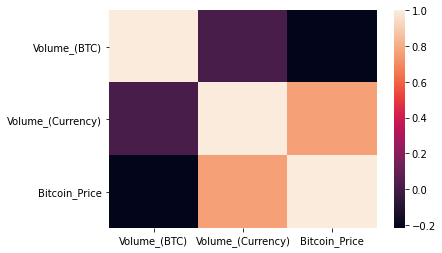

In [35]:
sns.heatmap(corr)

(0.0, 64503.905400931464)

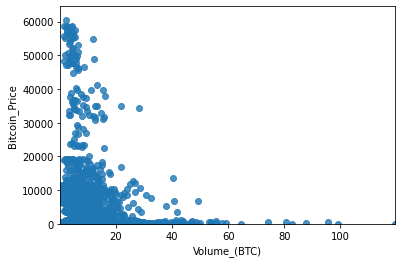

In [36]:
#checking the linear relationship b/w "Volume_(BTC)" & "Bitcoin_Price"
sns.regplot(x="Volume_(BTC)", y="Bitcoin_Price", data=df)# We can't understand any relationship between these two variables
plt.ylim(0,)

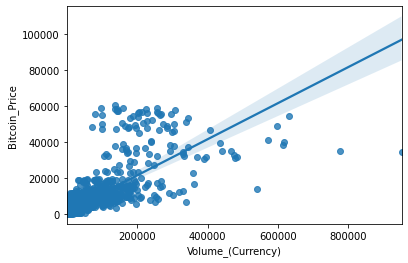

In [37]:
#checking the linear relationship b/w "Volume_(Currency)" & "Bitcoin_Price"
sns.regplot(x="Volume_(Currency)", y="Bitcoin_Price", data=df)

P-value is the probability value which shows that the correlation between the two 
variables is statistically significant. Normally, we choose a significance level of 0.05 i.e P-value < 0.05.

In [38]:
#Checking p-value of "Volume_(BTC"
pearson_coef, p_value = stats.pearsonr(df['Volume_(BTC)'], df['Bitcoin_Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
if p_value < 0.05:
  print('Correlation is significant')
else:
  print('Correlation is not significant')

The Pearson Correlation Coefficient is -0.2168844246277431  with a P-value of P = 3.154215364708349e-37
Correlation is significant


We can see that p_value is statistically significant although linear relationship is weak.

In [39]:
#***********************************8
#Checking p-value of "Volume_(Currency)"
pearson_coef, p_value = stats.pearsonr(df['Volume_(Currency)'], df['Bitcoin_Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
if p_value < 0.05:
  print('Correlation is significant')
else:
  print('Correlation is not significant')

The Pearson Correlation Coefficient is 0.7668042851401486  with a P-value of P = 0.0
Correlation is significant


In [40]:
df.columns


Index(['Volume_(BTC)', 'Volume_(Currency)', 'Bitcoin_Price'], dtype='object')

Analysis shows that 'Volume_(BTC) can't use as a feature in training data. So, we are going to drop this column.

In [41]:
df.drop(['Volume_(BTC)'] , inplace=True, axis=1)
df

,Volume_(Currency),Bitcoin_Price
Timestamp,,
2011-12-31,106.330084,4.471603
2012-01-01,35.259720,4.806667
2012-01-02,95.240000,5.000000
2012-01-03,58.100651,5.252500
2012-01-04,63.119577,5.208159
...,...,...
2021-03-27,100884.732367,55193.357260
2021-03-28,80632.115263,55832.958824
2021-03-29,213754.555988,56913.993819


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff432970990>,
      dtype=object)

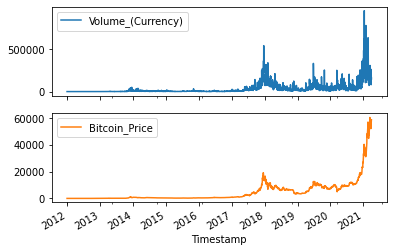

In [42]:
df['Timestamp'] = df.index #reseting "Timestamp" from index to column, only to plot the data w.r.t Timestamp 
df.set_index('Timestamp')[[
       'Volume_(Currency)', 'Bitcoin_Price']].plot(subplots=True) #Before this command it is important to convert into timestamp format because it plot the data w.r.t timestamp. This command is some of the commands that are used to plot time series data.We set the Timestamp as index by using 'Volume_(BTC)' command.

In [43]:
df

,Volume_(Currency),Bitcoin_Price,Timestamp
Timestamp,,,
2011-12-31,106.330084,4.471603,2011-12-31
2012-01-01,35.259720,4.806667,2012-01-01
2012-01-02,95.240000,5.000000,2012-01-02
2012-01-03,58.100651,5.252500,2012-01-03
2012-01-04,63.119577,5.208159,2012-01-04
...,...,...,...
2021-03-27,100884.732367,55193.357260,2021-03-27
2021-03-28,80632.115263,55832.958824,2021-03-28
2021-03-29,213754.555988,56913.993819,2021-03-29


In [44]:
df.drop(['Timestamp'] , inplace=True, axis=1)# As Timestamp is both index and column so dropping the "Timestamp" column.
df

,Volume_(Currency),Bitcoin_Price
Timestamp,,
2011-12-31,106.330084,4.471603
2012-01-01,35.259720,4.806667
2012-01-02,95.240000,5.000000
2012-01-03,58.100651,5.252500
2012-01-04,63.119577,5.208159
...,...,...
2021-03-27,100884.732367,55193.357260
2021-03-28,80632.115263,55832.958824
2021-03-29,213754.555988,56913.993819


From the last graph it looks like that the data is non-stationary. The stationary data have constant statistical properties like mean, variance and covariance.(Also autocorelation etc). Checking the stationarity of data(Timeseries).

######i) Dickey–Fuller test

In [45]:
#To check wheather our data is stationary or non_stationary we are going to perform Augmented Dickey-Fuller Test
# For this purpose we are defining a function
def stationarity_check(time_series):
  results=adfuller(time_series)
  print("Test_statistics=",results[0],'  P_value=' , results[1], "     Lags_used =",results[2],"   Number of Observation Used =",results[3],"  P_value Statistics=  ",results[4])


In [46]:
#stationarity checking for "Bitcoin_Price"
stationarity_check(df['Bitcoin_Price'])
# "Test_statistics" more negitive mean more likely to be stationary
#If "P_Value" is less than 0.05 than it must be stationary and we will reject our Null Hypothesis

Test_statistics= 6.185633110386273   P_value= 1.0      Lags_used = 29    Number of Observation Used = 3346   P_value Statistics=   {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


We can see that fourth element of our resulted touple gives us the dictionary which contain the critical test statistics. (At second position of this dictionary)We can see that Test_statistics value should be below mentioned value (of key 5%) if we want P_value of 5% or 0.05.

In [47]:
#stationarity checking for 'Volume_(Currency)'
stationarity_check(df['Volume_(Currency)'])

Test_statistics= -2.794664696742418   P_value= 0.0590399289296035      Lags_used = 28    Number of Observation Used = 3347   P_value Statistics=   {'1%': -3.432305280050264, '5%': -2.8624039284695777, '10%': -2.5672298862441107}


A second Test we can also perform to check the stationarity of our data. Splitting the timeseries into two or more partition and checking the mean and variance of each. 

###### ii) Mean and Variance Difference Test

In [48]:
df.shape


(3376, 2)

In [49]:
#splitting dataframe into two
df1=df[0:410]
df2=df[410:820]

In [50]:
#Checking the mean of df1
df1.mean()

Volume_(Currency)    183.753112
Bitcoin_Price          9.153317
dtype: float64

In [51]:
#Checking the mean of df2
df2.mean()

Volume_(Currency)    5128.825247
Bitcoin_Price         315.067788
dtype: float64

We can see that both dataframes have different mean values so we have not constant mean in whole dataframe. Now checking the variance.

In [52]:
df1.var()

Volume_(Currency)    20294.536018
Bitcoin_Price           17.463726
dtype: float64

In [53]:
df2.var()

Volume_(Currency)    5.619742e+07
Bitcoin_Price        9.157919e+04
dtype: float64

So it is clear that our timeseries is non-stationary. So, first of all we will make it stationary. There are multiple method to convert non-stationary timeseries into stationary form.

1.   Differencing or Seasonal Differencing
2.   Transformation
3.    Rolling Statistics


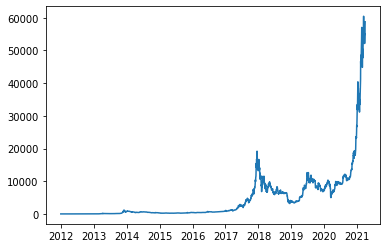

In [54]:
#Checking the trend of "Bitcoin_Price"
plt.plot(df['Bitcoin_Price'])


We are going to use differencing method first.

In [55]:
#We are going to make another column where we can store our difference(Using differencing method)
#df['Bitcoin_Price_df'] = df['Bitcoin_Price'] - df['Bitcoin_Price'].shift(1)#"shift(1)" we want to subtract the last value
#df['Bitcoin_Price_df'].head(3)



In [56]:

#df['Volume_(Currency)_df'] = df['Volume_(Currency)'] - df['Volume_(Currency)'].shift(1)#"shift(1)" we want to subtract the last value
#df['Volume_(Currency)_df'].head(3)

In [57]:
#Removing the NAN values(Because there is no value before first value to make difference so there is a NAN in the beginning)

#df.dropna(axis=0, inplace=True)

# reset indexs
#df.reset_index(drop=False, inplace=True)
#df.head(5)

In [58]:
#stationarity_check(df['Bitcoin_Price_df'])

In [59]:
#stationarity_check(df['Volume_(Currency)_df'])

In [60]:
#splitting dataframe into two
#df3=df[0:410]
#df4=df[410:820]

In [61]:
#df3.mean()

In [62]:
#df4.mean()

In [63]:
#df3.var()

In [64]:
#df4.var()

In [65]:
#df['Volume_(Currency)_df'].plot()

In [66]:

#df['Bitcoin_Price_df'].plot()

Checking some other methods

In [67]:
#Using Transformation method we are trying to make our data stationary
df['Bitcoin_Price_log']=np.log10(df['Bitcoin_Price'])#log calculation
#df['Bitcoin_Price_sqrt']=np.sqrt(df['Bitcoin_Price'])#square root calculatiion
#df['Bitcoin_Price_cbrt']=np.cbrt(df['Bitcoin_Price'])#cube root calculation
#Differencing these time series
df['BC_log']=df['Bitcoin_Price_log']-df['Bitcoin_Price_log'].shift(1)
#df['BC_sqrt']=df['Bitcoin_Price_sqrt']-df['Bitcoin_Price_sqrt'].shift(1)
#df['BC_cbrt']=df['Bitcoin_Price_cbrt']-df['Bitcoin_Price_cbrt'].shift(1)
#removing NAN values
#df[['BC_log']].dropna(axis=0,inplace=True)
#df[['BC_sqrt']].dropna(axis=0,inplace=True)
#df[['BC_cbrt']].dropna(axis=0,inplace=True)

In [68]:
df.dropna(subset=['BC_log'], axis=0, inplace=True)

# reset index, because we droped many rows
df.reset_index(drop=False, inplace=True)
df

,Timestamp,Volume_(Currency),Bitcoin_Price,Bitcoin_Price_log,BC_log
0,2012-01-01,35.259720,4.806667,0.681844,0.031381
1,2012-01-02,95.240000,5.000000,0.698970,0.017126
2,2012-01-03,58.100651,5.252500,0.720366,0.021396
3,2012-01-04,63.119577,5.208159,0.716684,-0.003682
4,2012-01-05,27.987370,6.284127,0.798245,0.081561
...,...,...,...,...,...
3370,2021-03-27,100884.732367,55193.357260,4.741887,0.015640
3371,2021-03-28,80632.115263,55832.958824,4.746891,0.005004
3372,2021-03-29,213754.555988,56913.993819,4.755219,0.008328
3373,2021-03-30,138231.241926,58346.912268,4.766018,0.010799


In [69]:
df.shape

(3375, 5)

In [70]:
df5=df[0:410]
df6=df[410:819]

In [71]:
df5.mean()

Volume_(Currency)    184.681987
Bitcoin_Price          9.204725
Bitcoin_Price_log      0.920648
BC_log                 0.001846
dtype: float64

In [72]:
df6.mean()

Volume_(Currency)    5140.174041
Bitcoin_Price         315.775658
Bitcoin_Price_log       2.286545
BC_log                  0.003157
dtype: float64

In [73]:
df5.var()

Volume_(Currency)    20504.103134
Bitcoin_Price           18.064755
Bitcoin_Price_log        0.037202
BC_log                   0.000217
dtype: float64

In [74]:
df6.var()

Volume_(Currency)    5.628222e+07
Bitcoin_Price        9.159770e+04
Bitcoin_Price_log    1.914643e-01
BC_log               9.137152e-04
dtype: float64

In [75]:
stationarity_check(df['BC_log'])

Test_statistics= -10.530767454563131   P_value= 9.164529245225308e-19      Lags_used = 23    Number of Observation Used = 3351   P_value Statistics=   {'1%': -3.4323029442926765, '5%': -2.862402896767871, '10%': -2.567229336991118}


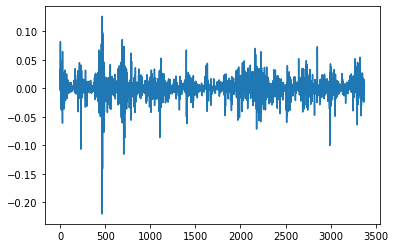

In [76]:
#Plotting 
df['BC_log'].plot()

In [77]:
df.columns

Index(['Timestamp', 'Volume_(Currency)', 'Bitcoin_Price', 'Bitcoin_Price_log',
       'BC_log'],
      dtype='object')

Data seems to be much batter now. It is important to convert'Volume_(Currency)' into stationary format.

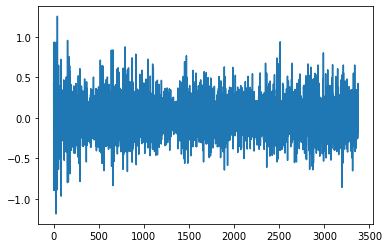

In [78]:
##############remove other procedure if not required
#Using Transformation method we are trying to make our data stationary
df['Volume_(Currency)_log']=np.log10(df['Volume_(Currency)'])#log calculation
#df['Bitcoin_Price_sqrt']=np.sqrt(df['Bitcoin_Price'])#square root calculatiion
#df['Bitcoin_Price_cbrt']=np.cbrt(df['Bitcoin_Price'])#cube root calculation
#Differencing these time series
df['Volume_log']=df['Volume_(Currency)_log']-df['Volume_(Currency)_log'].shift(1)
#df['BC_sqrt']=df['Bitcoin_Price_sqrt']-df['Bitcoin_Price_sqrt'].shift(1)
#df['BC_cbrt']=df['Bitcoin_Price_cbrt']-df['Bitcoin_Price_cbrt'].shift(1)
#removing NAN values
#df[['BC_log']].dropna(axis=0,inplace=True)
#df[['BC_sqrt']].dropna(axis=0,inplace=True)
#df[['BC_cbrt']].dropna(axis=0,inplace=True)

df.dropna(subset=['Volume_log'], axis=0, inplace=True)

# reset index, because we droped many rows
df.reset_index(drop=False, inplace=True)

df5=df[0:410]
df6=df[410:819]

df['Volume_log'].plot()


In [79]:
stationarity_check(df['Volume_log'])

Test_statistics= -14.343121123051958   P_value= 1.0518494379322131e-26      Lags_used = 27    Number of Observation Used = 3346   P_value Statistics=   {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


In [80]:
df5.mean()

index                    205.500000
Volume_(Currency)        186.902907
Bitcoin_Price              9.255937
Bitcoin_Price_log          0.922428
BC_log                     0.001780
Volume_(Currency)_log      2.113064
Volume_log                 0.003484
dtype: float64

In [81]:
df6.mean()

index                     615.000000
Volume_(Currency)        5164.755111
Bitcoin_Price             316.855125
Bitcoin_Price_log           2.289621
BC_log                      0.003076
Volume_(Currency)_log       3.366736
Volume_log                  0.002605
dtype: float64

In [82]:
df5.var()

index                    14042.500000
Volume_(Currency)        21861.089176
Bitcoin_Price               18.688472
Bitcoin_Price_log            0.037648
BC_log                       0.000215
Volume_(Currency)_log        0.181959
Volume_log                   0.081697
dtype: float64

In [83]:
df6.var()

index                    1.397417e+04
Volume_(Currency)        5.632265e+07
Bitcoin_Price            9.144672e+04
Bitcoin_Price_log        1.899385e-01
BC_log                   9.162093e-04
Volume_(Currency)_log    2.947284e-01
Volume_log               6.567699e-02
dtype: float64

In [84]:
#d_frame.index = d_frame.Timestamp
# Resampling datframe on daily frequency basis
#df_day = d_frame.resample('D').mean()

# # Resampling datframe on monthly frequency basis
#df_m = d_frame.resample('M').mean()

# # Resampling datframe on anual frequency basis
#df_y = d_frame.resample('A-DEC').mean()

# # Resampling datframe on quarterly frequency basis
#df_Q = d_frame.resample('Q-DEC').mean()# For making it short after analysing these all data sets we are going to df_m for our further analysis


In [85]:
df.describe()

,index,Volume_(Currency),Bitcoin_Price,Bitcoin_Price_log,BC_log,Volume_(Currency)_log,Volume_log
count,3374.000000,3374.000000,3374.000000,3374.000000,3374.000000,3374.000000,3374.000000
mean,1687.500000,31809.612876,4608.303731,2.927839,0.001211,3.819738,0.001083
std,974.134231,62767.823416,8208.699453,1.021955,0.016804,0.925960,0.234952
min,1.000000,1.227500,4.331667,0.636655,-0.220358,0.089022,-1.186814
25%,844.250000,1918.275718,245.159152,2.389448,-0.004370,3.282911,-0.151068
50%,1687.500000,6834.994315,699.637248,2.844872,0.000870,3.834738,-0.010526
75%,2530.750000,36153.192445,7243.657526,3.859958,0.007340,4.558146,0.140288
max,3374.000000,950995.602917,60455.844831,4.781438,0.126267,5.978179,1.252703


We can see that our data have many outliers in almost all columns.

In [86]:
df.query('BC_log	>0.007056')# We have used 75% value to check outliers.(in BC_log)

,index,Timestamp,Volume_(Currency),Bitcoin_Price,Bitcoin_Price_log,BC_log,Volume_(Currency)_log,Volume_log
0,1,2012-01-02,95.240000,5.000000,0.698970,0.017126,1.978819,0.431541
1,2,2012-01-03,58.100651,5.252500,0.720366,0.021396,1.764181,-0.214638
3,4,2012-01-05,27.987370,6.284127,0.798245,0.081561,1.446962,-0.353202
4,5,2012-01-06,15.914659,6.438999,0.808818,0.010573,1.201797,-0.245165
5,6,2012-01-07,2.011834,6.800000,0.832509,0.023691,0.303592,-0.898205
...,...,...,...,...,...,...,...,...
3360,3361,2021-03-18,224746.087533,58472.117322,4.766949,0.017537,5.351692,-0.007430
3368,3369,2021-03-26,180619.174558,53241.037489,4.726247,0.009228,5.256764,-0.125203
3369,3370,2021-03-27,100884.732367,55193.357260,4.741887,0.015640,5.003825,-0.252938
3371,3372,2021-03-29,213754.555988,56913.993819,4.755219,0.008328,5.329915,0.423407


In [87]:
df.query('BC_log	<-0.003926')# We have used 25% value to check outliers. 

,index,Timestamp,Volume_(Currency),Bitcoin_Price,Bitcoin_Price_log,BC_log,Volume_(Currency)_log,Volume_log
7,8,2012-01-09,12.306798,6.582770,0.818409,-0.023576,1.090145,-0.147901
11,12,2012-01-13,10.779292,6.969237,0.843185,-0.005773,1.032590,-0.664974
12,13,2012-01-14,10.848680,6.414081,0.807134,-0.036051,1.035377,0.002787
14,15,2012-01-16,12.392857,6.714286,0.827000,-0.027306,1.093171,-0.284863
15,16,2012-01-17,20.558575,6.148346,0.788758,-0.038242,1.312993,0.219822
...,...,...,...,...,...,...,...,...
3358,3359,2021-03-16,295647.294866,55339.804792,4.743038,-0.016689,5.470774,-0.016293
3363,3364,2021-03-21,144363.205985,57312.598536,4.758250,-0.010978,5.159457,0.169364
3364,3365,2021-03-22,255685.092495,56787.148422,4.754250,-0.004000,5.407705,0.248249
3365,3366,2021-03-23,189536.245426,54703.387740,4.738014,-0.016236,5.277692,-0.130013


In [88]:
df.columns

Index(['index', 'Timestamp', 'Volume_(Currency)', 'Bitcoin_Price',
       'Bitcoin_Price_log', 'BC_log', 'Volume_(Currency)_log', 'Volume_log'],
      dtype='object')

In [89]:
df.drop(['index','Volume_(Currency)', 'Bitcoin_Price',
       'Bitcoin_Price_log','Volume_(Currency)_log'] , inplace=True, axis=1)# As Timestamp is both index and column so dropping the "Timestamp" column.
df

,Timestamp,BC_log,Volume_log
0,2012-01-02,0.017126,0.431541
1,2012-01-03,0.021396,-0.214638
2,2012-01-04,-0.003682,0.035983
3,2012-01-05,0.081561,-0.353202
4,2012-01-06,0.010573,-0.245165
...,...,...,...
3369,2021-03-27,0.015640,-0.252938
3370,2021-03-28,0.005004,-0.097317
3371,2021-03-29,0.008328,0.423407
3372,2021-03-30,0.010799,-0.189309


In [90]:
df.dtypes

Timestamp      object
BC_log        float64
Volume_log    float64
dtype: object

In [91]:
df_in=df[['BC_log','Volume_log']]  # Time stamp is not included in input dataframe

We can also check other colums for number of outliers. Standard scaler will not account the outliers so we use "MinMaxScaler"

In [92]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(df_in)
scaled_data #Data is b/w 0 and 1

array([[0.68513255, 0.66339155],
       [0.69745153, 0.39851169],
       [0.62510274, 0.50124574],
       ...,
       [0.65975182, 0.66005761],
       [0.66687884, 0.40889457],
       [0.64465662, 0.51188202]])

In [93]:
features=scaled_data           #(Multivariate data going to be the input of LSTM model)All columns including 'BC_log' because we want to predict future values using past values of 'BC_log' along with other variables (Timestamp is not icluded). All
target=scaled_data[:,-1]        #only 'BC_log' column (Timestamp is not included)

In [94]:
features

array([[0.68513255, 0.66339155],
       [0.69745153, 0.39851169],
       [0.62510274, 0.50124574],
       ...,
       [0.65975182, 0.66005761],
       [0.66687884, 0.40889457],
       [0.64465662, 0.51188202]])

In [95]:
target

array([0.66339155, 0.39851169, 0.50124574, ..., 0.66005761, 0.40889457,
       0.51188202])

In [96]:
features.shape

(3374, 2)

In [97]:
target.shape

(3374,)

In [98]:
# Splitting the Training and Test data
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.04,random_state=42,shuffle=False)

In [99]:
x_train.shape

(3239, 2)

In [100]:
x_test.shape #We wnant to predict the price of Bitcoin in the spam of one month

(135, 2)

In [101]:
y_train.shape

(3239,)

In [102]:
y_test.shape

(135,)

### 6- Model Development and Compilation

In [103]:
win_length=1
batch_size=32
num_features=2
# Time series generator is used to prepare data.Feature column(x_train or x_test) & Target column(y_train,y_test) are passed.
#window_length is number of time periods of data. It will take these numbers of time periods of data and predict the next.
train_generator=TimeseriesGenerator(x_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator=TimeseriesGenerator(x_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)

train_generator[0] #it will contain 32 observations equal to "batch_size" each have further observations equal to "win_length" & further each observation contain equal to "num_features" features.The are also 32 target columns equel to batch size 

(array([[[0.68513255, 0.66339155]],
 
        [[0.69745153, 0.39851169]],
 
        [[0.62510274, 0.50124574]],
 
        [[0.87102456, 0.34171208]],
 
        [[0.66622851, 0.3859984 ]],
 
        [[0.70407107, 0.11830592]],
 
        [[0.66306225, 0.8695444 ]],
 
        [[0.56770821, 0.42586848]],
 
        [[0.63956923, 0.50653991]],
 
        [[0.73029518, 0.50728298]],
 
        [[0.6254446 , 0.69465586]],
 
        [[0.61906895, 0.21391119]],
 
        [[0.53171938, 0.48763795]],
 
        [[0.77181309, 0.62695684]],
 
        [[0.55694705, 0.36972546]],
 
        [[0.52539912, 0.5766043 ]],
 
        [[0.65440244, 0.50494685]],
 
        [[0.63271468, 0.76688463]],
 
        [[0.7527081 , 0.39181341]],
 
        [[0.55059037, 0.56826715]],
 
        [[0.65499927, 0.39901008]],
 
        [[0.62066114, 0.44877005]],
 
        [[0.65282579, 0.39652868]],
 
        [[0.59417139, 0.34804558]],
 
        [[0.61571156, 0.45069892]],
 
        [[0.52287137, 0.57475992]],
 
        [[0.

In [104]:
model = Sequential()
# In following line of code,128 is LSTM output.We set"return_sequences=True" because we require hidden state for each of our input data otherwise it will return
#only one hidden state for all the input data.it is time series data so we need to have hidde state for each and every observation.
model.add(LSTM(128,input_shape=(win_length,num_features),return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))# return only single hidden state. If we want to further use other layers before final layer we can set it equel to true.
model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            67072     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [113]:
# Early stopping is if our validation loss is not improving then it will stop the training earlier.it will observe 2 iterations for validation loss improvement.
#earl_stop=EarlyStopping(monitor="val_loss",patience=10,mode='min')

In [114]:
#Compiling the model
#model.compile(loss='mse', optimizer='adam', metrics=['mae'])
#or
#model.compile(loss = MeanSquaredError(), optimizer=Adam(),metrics =[MeanAbsoluteError()])

### 7-Model Training 

In [115]:
#epochs=100
#Training our model
#history=model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,shuffle=False,callbacks=earl_stop)

In [116]:
#saving the model

#model_json = model.to_json()
#with open("model_final.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("final_model.h5")

### 8-Model Evaluation and Prediction

In [117]:
#model.evaluate(test_generator,verbose=0)# checking the performance of our model

In [118]:
#predict=model.predict_generator(test_generator)

In [119]:
#predict